# Attractor Class

The class below represents a attractor of the form:

$$x_{n+1} = a_{0} + a_{1} x + a_{2} x^{2} + a_{3} x y + a_{4} y + a_{5} y^{2}$$
$$y_{n+1} = b_{0} + b_{1} x + b_{2} x^{2} + b_{3} x y + b_{4} y + b_{5} y^{2}$$

This equation show the evolution of the position of a point. Depending on the coefficients $a_n$ and $b_n$, the point could exibit diferrente behaviours, like diverging to infinite, converge to a point, converge to a periodic path, or, more intriguing, exibit chaotic behavior.

Because the behaviour of the point also depends in its start position, the class also keep track of it.

The class also have some utilities for simulating and drawing the attractor.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def point(x,y):
    return np.array((x,y))

# A attractor is represent by 12 coefficients, and a start point
class Attractor:
    def __init__(self, a, b, start):
        self.a = a
        self.b = b
        self.start = start

    def __eq__(self, other):
        if not isinstance(other, Attractor):
            return False

        np.all(np.isclose(self.a, other.a)) \
            and np.all(np.isclose(self.b, other.b)) \
            and np.all(np.isclose(self.start, other.start))
        
    def __repr__(self):
        return f"Attractor(a: {repr(self.a)} b: {repr(self.b)} start: {repr(self.start)})"
         
    def __str__(self):
       return self.__repr__()

    def step(self, p):
        x, y = p
        a = self.a
        b = self.b
        x_ = a[0] + a[1] * x + a[2] * x * x + a[3] * x * y + a[4] * y + a[5] * y * y
        y_ = b[0] + b[1] * x + b[2] * x * x + b[3] * x * y + b[4] * y + b[5] * y * y    
        return point(x_, y_)

    def points(self, steps=20_000):
        points = []
        p = self.start
        for _ in range(steps):
            points.append(p)
            p = self.step(p)
        return np.array(points)

    def bounds(self):
        points = self.points(2000)
        min = np.min(points, axis=0)
        max = np.max(points, axis=0)
        return [min[0], min[1], max[0], max[1]]

    def plot(self, steps=20_000, ax=None):
        show = True
        if ax is None:
            ax = plt.subplot()
            show = False
        points = self.points(steps)
        ax.hist2d(points[:,0], points[:,1], bins=256, cmap='magma')
        if False:
            plt.show()


Below is a sample of coefficients of a strange attractor, found by computing a Lyapunov exponent of random attractors, using the Rust library in this repo.

In [3]:
# attractor coeffs
attractor = Attractor(
    [-0.802243685889652, -0.7382286188777996, -0.0944374765376077, 0.7641307088312401, 0.6233616584624198, -0.23712654279852563],
    [-0.19267885929 960515, 0.2039614784519026, -0.6541177705006249, -0.9701057811993836, 0.06365569587029007, 0.6886405763163101],
    [-1.1947977593988424, 0.0009408270966647647],
)

print(attractor.bounds())
attractor.plot()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1639032428.py, line 4)

[-3.423145011899551, -2.0204218105906193, 1.091929342719109, 0.45512912451125714]


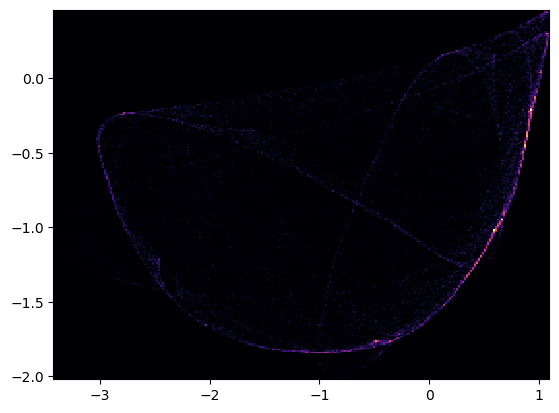

In [2]:
# attractor coeffs
a = [0.9744697514419727, -0.17934047509025497, -0.04901336948461976, -0.27075445727111846, 0.9434238008370688, -0.5221358982015021]
b = [0.21662913237260994, -0.6214019887146689, -0.3976124161503871, 0.5672469413539543, 0.9689535842169716, -0.13760618334984365]
attractor = Attractor(np.array(a), np.array(b), point(0.0, 0.0)) 

print(attractor.bounds())
attractor.plot()

## Transforming Attractors

One can transform the graphic of a attractor by applying a transformation to each one of the points that forms it. For example, you can apply a translate by adding a value $t_x$ to the $x$ coordinate of the point, and $t_y$ to $y$:

$$x'_{n} = x_{n} + t_x$$
$$y'_{n} = y_{n} + t_y$$

Notice that you can also do the inverse:

$$x'_{n} - t_x = x_{n}$$
$$y'_{n} - t_y = y_{n}$$

You can also replace $x_n$ by $f_x(x_{n-1}, y_x{n-1})$, where $f_x$ is the evolution of the x coordinate of the point in the attractor:

$$x'_{n} = f(x_{n-1}, y_{n-1}) + t_x$$

And you can also apply $x_{n+-1} = x'_{n-1} - t_x$:

$$x'_{n} = f(x'_{n-1} - t_x, y'_{n-1} - t_x) + t_x$$

And if you expand $f$:

$$
x'_{n+1} = a_{0} + a_{1} t_{x} + \left(a_{1} + 2 a_{2} t_{x}\right) x'_{n-1} + a_{2} t_{x}^{2}
a_{2} {x'}^{2}_{n-1} + a_{3} x'_{n-1} 
\left(a_{3} t_{x} + a_{4}\right) y'_{n-1} + a_{5} {y'}^{2}_{n-1}
$$

We reach in a equation in the same form as the original equation, with the only
diferrence being the constants! This means that we can apply a translation to
the atractor by just changing its coeficients and starting point.
 
More generally, we apply any transformation affine transformation $A p + t$,
where $p$ is the vector $[x, y]$, $A$ is a 2x2 matrix, and $t$ is a vector. We
only need to expand the following equation:

$p_{n+1} = A^{-1} \big(f(A \; p_{n} + t) - t\big)$

Expading it by hand was expected to be too labourous to be attempted, so I use
SymPy to derive it.


In [3]:
from sympy import *

coeff_a = IndexedBase('a', 6)
coeff_b = IndexedBase('b', 6)
x, y = symbols('x y')
p = Matrix([x, y])

def step(p):
    x = p[0]
    y = p[1]
    return Matrix([
        coeff_a[0] + coeff_a[1] * x + coeff_a[2] * x * x + coeff_a[3] * x * y + coeff_a[4] * y + coeff_a[5] * y * y,
        coeff_b[0] + coeff_b[1] * x + coeff_b[2] * x * x + coeff_b[3] * x * y + coeff_b[4] * y + coeff_b[5] * y * y,
    ])

step_x = step(p)
step_x

Matrix([
[x**2*a[2] + x*y*a[3] + x*a[1] + y**2*a[5] + y*a[4] + a[0]],
[x**2*b[2] + x*y*b[3] + x*b[1] + y**2*b[5] + y*b[4] + b[0]]])

In [4]:
# A and t, such that `f(x) = A*x + t` is affine transformation
A = IndexedBase('A', 4)
A = Matrix(2,2, (A[0], A[1], A[2], A[3]))
t = IndexedBase('t', 2)
t = Matrix(2, 1, (t[0], t[1]))

# This has the effect of applying a affine transformation to the output image
step_x_affine = A**-1 * (step(A * p + t) - t)
step_x_affine

Matrix([
[ ((x*A[0] + y*A[1] + t[0])**2*a[2] + (x*A[0] + y*A[1] + t[0])*(x*A[2] + y*A[3] + t[1])*a[3] + (x*A[0] + y*A[1] + t[0])*a[1] + (x*A[2] + y*A[3] + t[1])**2*a[5] + (x*A[2] + y*A[3] + t[1])*a[4] + a[0] - t[0])*A[3]/(A[0]*A[3] - A[1]*A[2]) - ((x*A[0] + y*A[1] + t[0])**2*b[2] + (x*A[0] + y*A[1] + t[0])*(x*A[2] + y*A[3] + t[1])*b[3] + (x*A[0] + y*A[1] + t[0])*b[1] + (x*A[2] + y*A[3] + t[1])**2*b[5] + (x*A[2] + y*A[3] + t[1])*b[4] + b[0] - t[1])*A[1]/(A[0]*A[3] - A[1]*A[2])],
[-((x*A[0] + y*A[1] + t[0])**2*a[2] + (x*A[0] + y*A[1] + t[0])*(x*A[2] + y*A[3] + t[1])*a[3] + (x*A[0] + y*A[1] + t[0])*a[1] + (x*A[2] + y*A[3] + t[1])**2*a[5] + (x*A[2] + y*A[3] + t[1])*a[4] + a[0] - t[0])*A[2]/(A[0]*A[3] - A[1]*A[2]) + ((x*A[0] + y*A[1] + t[0])**2*b[2] + (x*A[0] + y*A[1] + t[0])*(x*A[2] + y*A[3] + t[1])*b[3] + (x*A[0] + y*A[1] + t[0])*b[1] + (x*A[2] + y*A[3] + t[1])**2*b[5] + (x*A[2] + y*A[3] + t[1])*b[4] + b[0] - t[1])*A[0]/(A[0]*A[3] - A[1]*A[2])]])

In [5]:
def evidence_x_y(expr):
    return collect(expand(expr, [x, y]), [x, y, x*y])

step_x_affine_simpl = step_x_affine.applyfunc(evidence_x_y)
step_x_affine_simpl

Matrix([
[x**2*(-A[0]**2*A[1]*b[2]/(A[0]*A[3] - A[1]*A[2]) + A[0]**2*A[3]*a[2]/(A[0]*A[3] - A[1]*A[2]) - A[0]*A[1]*A[2]*b[3]/(A[0]*A[3] - A[1]*A[2]) + A[0]*A[2]*A[3]*a[3]/(A[0]*A[3] - A[1]*A[2]) - A[1]*A[2]**2*b[5]/(A[0]*A[3] - A[1]*A[2]) + A[2]**2*A[3]*a[5]/(A[0]*A[3] - A[1]*A[2])) + x*y*(-2*A[0]*A[1]**2*b[2]/(A[0]*A[3] - A[1]*A[2]) + 2*A[0]*A[1]*A[3]*a[2]/(A[0]*A[3] - A[1]*A[2]) - A[0]*A[1]*A[3]*b[3]/(A[0]*A[3] - A[1]*A[2]) + A[0]*A[3]**2*a[3]/(A[0]*A[3] - A[1]*A[2]) - A[1]**2*A[2]*b[3]/(A[0]*A[3] - A[1]*A[2]) + A[1]*A[2]*A[3]*a[3]/(A[0]*A[3] - A[1]*A[2]) - 2*A[1]*A[2]*A[3]*b[5]/(A[0]*A[3] - A[1]*A[2]) + 2*A[2]*A[3]**2*a[5]/(A[0]*A[3] - A[1]*A[2])) + x*(-A[0]*A[1]*b[1]/(A[0]*A[3] - A[1]*A[2]) - 2*A[0]*A[1]*b[2]*t[0]/(A[0]*A[3] - A[1]*A[2]) - A[0]*A[1]*b[3]*t[1]/(A[0]*A[3] - A[1]*A[2]) + A[0]*A[3]*a[1]/(A[0]*A[3] - A[1]*A[2]) + 2*A[0]*A[3]*a[2]*t[0]/(A[0]*A[3] - A[1]*A[2]) + A[0]*A[3]*a[3]*t[1]/(A[0]*A[3] - A[1]*A[2]) - A[1]*A[2]*b[3]*t[0]/(A[0]*A[3] - A[1]*A[2]) - A[1]*A[2]*b[4]/(A[0

In [6]:
def extract_coeffs(expr):
    degress = [(0,0), (1,0), (2,0), (1,1), (0,1), (0,2)]
    coeffs = []
    for i, (x_deg, y_deg) in enumerate(degress):
        coeffs.append(simplify(expr.coeff(x, x_deg).coeff(y, y_deg)))
    return Matrix([coeffs])

coeffs = step_x_affine_simpl.applyfunc(extract_coeffs)
coeffs[0][0]

(-A[1]*b[0] - A[1]*b[1]*t[0] - A[1]*b[2]*t[0]**2 - A[1]*b[3]*t[0]*t[1] - A[1]*b[4]*t[1] - A[1]*b[5]*t[1]**2 + A[1]*t[1] + A[3]*a[0] + A[3]*a[1]*t[0] + A[3]*a[2]*t[0]**2 + A[3]*a[3]*t[0]*t[1] + A[3]*a[4]*t[1] + A[3]*a[5]*t[1]**2 - A[3]*t[0])/(A[0]*A[3] - A[1]*A[2])

In [7]:
apply_affine_to_attractor_a = lambdify([coeff_a, coeff_b, A, t], coeffs[0])
apply_affine_to_attractor_b = lambdify([coeff_a, coeff_b, A, t], coeffs[1])

def apply_affine_to_attractor(attractor, A, t):
    a = attractor.a
    b = attractor.b
    start = attractor.start
    
    a_ = np.squeeze(apply_affine_to_attractor_a(a, b, A.ravel(), t))
    b_ = np.squeeze(apply_affine_to_attractor_b(a, b, A.ravel(), t))

    start_ = (start - t) @ np.linalg.inv(A).T

    return Attractor(a_, b_, start_)

In [8]:
# testing

n_points = 5
points = attractor.points(n_points)

# apply identity
attractor_ = apply_affine_to_attractor(attractor, np.eye(2), np.zeros(2))
# assert attractor == attractor_

# random transformation
# s = np.random.rand(2,2)
# t = np.random.rand(2)
s = np.array([[10,0],[0,10]])
t = np.array([0,0])
attractor_ = apply_affine_to_attractor(attractor, s, t)
points_ = attractor_.points(n_points)
assert np.all(np.isclose(points_ @ s.T + t[np.newaxis, :], points))

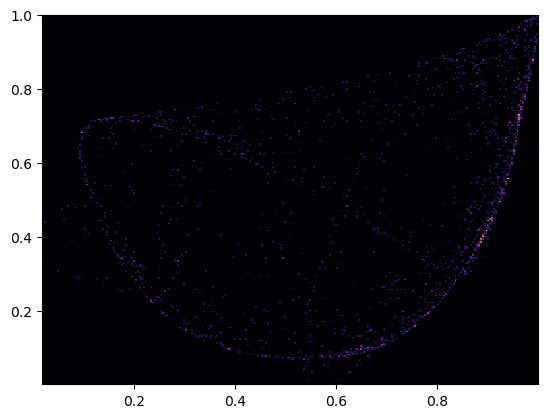

In [9]:
bounds = attractor.bounds()
scale_x = bounds[2] - bounds[0]
scale_y = bounds[3] - bounds[1]

affine = np.array([scale_x, 0.0, 0.0, scale_y]).reshape((2,2))
t = np.array([bounds[0], bounds[1]])

attractor_ = apply_affine_to_attractor(attractor, affine, t)
attractor_.plot(2000)

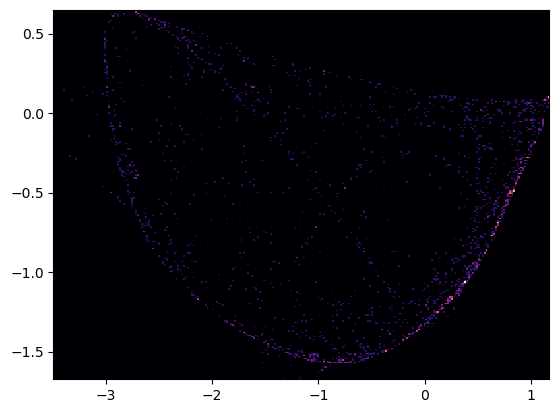

In [10]:
theta = np.pi / 10
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])
t = np.array([0,0])

apply_affine_to_attractor(attractor, rotation_matrix, t).plot(2000)

# Using affine transformations to fix Attractor

The advantage of beign able to apply any affine transformation to a attractor,
is being able to "fix" attractors that are too narrow.

For example, the attractor below:

[-3.9808126526517498, -3.7674607304111376, -0.6718097082002998, -1.3954686539980812]


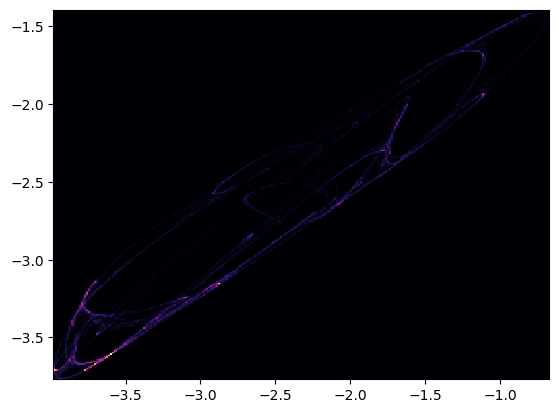

In [11]:
a = [-0.6302889425801008, 0.5553038135907626, 0.6554469376829828, -0.01750009582340173, -0.5896198687263134, -0.8883600803195559]
b = [-0.3336348668320812, 0.7535964162077504, 0.6397754261387409, -0.23796468275000393, 0.42198193547587426, -0.302060165859916]

attractor2 = Attractor(np.array(a), np.array(b), point(-2.29965666, -2.38230694)) 

print(attractor2.bounds())
attractor2.plot(200_000)

when plotting it, `matplotlib` automatically fit it the figure by adjusting the
plot limits, but in this case the attractor is squished diagonally.

To fix that we can apply a affine transformation.

On way of fixing it, is to find the direction direction of maximun variance,
and rotate the view to align to it. We can also measure the length of the
attractor along that direction, and its perpendicular, fitting the attractor to
a square.

In [12]:
def affine_from_pca(points):
    mean = np.median(points, axis=0)
    covariance = np.cov(points, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    print(eigenvalues, eigenvectors)

    principal_component = eigenvectors[:, np.argmax(eigenvalues)]
    pc = (points - mean) @ principal_component
    principal_length = np.max(np.abs(pc))
    
    perpendicular_component = np.array([
        -principal_component[1],
        principal_component[0],
    ])
    pc = (points - mean) @ perpendicular_component
    perpendicular_length = np.max(np.abs(pc))

    A = np.array([
        principal_length*principal_component,
        perpendicular_length*perpendicular_component,
    ]).T
    t = mean
    return (A, t)

[1.25572739 0.02681712] [[ 0.82736142 -0.5616699 ]
 [ 0.5616699   0.82736142]]
[[ 2.16259847 -0.17965952]
 [ 1.46812075  0.26464541]] [-2.84558334 -2.86486912]


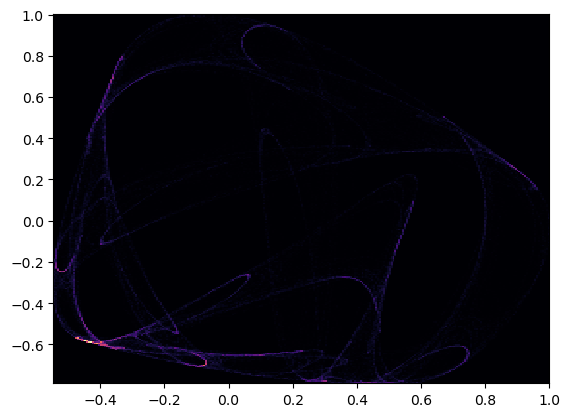

In [13]:
A, t = affine_from_pca(attractor2.points(500))
print(A, t)
apply_affine_to_attractor(attractor2, A, t).plot(100_000)

# Generating Rust code usin SymPy

This entire notebook was used to develop the math behind the attractors, but the actual rendering will be implemented in Rust, so I need to convert the math to Rust code. Fortunatelly, SymPy offers utilities for just that.

Reference: https://www.sympy.org/scipy-2017-codegen-tutorial/notebooks/07-the-hard-way.html

In [37]:
from sympy.printing.c import C99CodePrinter
from sympy.printing.rust import RustCodePrinter

settings = {'contract': False }
cprinter = C99CodePrinter(settings, type_aliases={real: float80})
rprinter = RustCodePrinter(settings)

new_a = MatrixSymbol('new_a', 6, 1)
new_b = MatrixSymbol('new_b', 6, 1)

print('C:')
print(cprinter.doprint(coeffs[0].T, assign_to=new_a))
print(cprinter.doprint(coeffs[0].T, assign_to=new_b))
print('Rust:')
print(rprinter.doprint(coeffs[0].T, assign_to=new_a))
print(rprinter.doprint(coeffs[1].T, assign_to=new_b))

NameError: name 'real' is not defined

The printer is using integer literals:

In [34]:
print(cprinter.doprint(Symbol('x_0') * 4* IndexedBase('a', 2)[0] * IndexedBase('a', 2)[1]))
print(rprinter.doprint(Symbol('x_0') * 4* IndexedBase('a', 2)[0] * IndexedBase('a', 2)[1]))

4*x_0*a[0]*a[1]
4*x_0*a[0]*a[1]


We can use a custom printer to fix that:

In [32]:
class MyPrinter(RustCodePrinter):
    def _print_Integer(self, expr):
        return str(expr) + ".0"

mprinter = MyPrinter(settings)
mprinter.doprint(Symbol('x_0') * 4* IndexedBase('a', 3)[2] + 3 * IndexedBase('a', 2)[1])

'4.0*x_0*a[2.0] + 3.0*a[1.0]'

## CSE



In [15]:
from sympy.codegen.ast import Assignment

sub_exprs, simplified_rhs = cse(coeffs)
code = ""
for var, expr in sub_exprs:
    code += "    let "+ rprinter.doprint(Assignment(var, expr)) + "\n"
code += "    " +  rprinter.doprint(simplified_rhs[0][0].T, assign_to=new_a)
code += "\n    " + rprinter.doprint(simplified_rhs[0][1].T, assign_to=new_b)
print(code)

    let x0 = A[0]*A[3];
    let x1 = A[1]*A[2];
    let x2 = (x0 - x1).recip();
    let x3 = A[3]*t[0];
    let x4 = A[1]*b[1];
    let x5 = A[1]*t[1];
    let x6 = (t[0]).powi(2);
    let x7 = A[1]*b[2];
    let x8 = (t[1]).powi(2);
    let x9 = A[1]*b[5];
    let x10 = x5*b[3];
    let x11 = x1*b[3];
    let x12 = 2*t[1];
    let x13 = x1*b[5];
    let x14 = A[2]*a[3];
    let x15 = A[3]*a[5];
    let x16 = A[2]*t[1];
    let x17 = A[0]*t[0];
    let x18 = x10*A[0] - x14*x3 - 2*x15*x16 + 2*x17*x7 + x4*A[0] - A[2]*A[3]*a[4];
    let x19 = (A[0]).powi(2);
    let x20 = x19*x7;
    let x21 = (A[2]).powi(2);
    let x22 = -x0*x14 + x11*A[0];
    let x23 = (A[1]).powi(2);
    let x24 = x23*b[3];
    let x25 = (A[3]).powi(2);
    let x26 = A[0]*b[2];
    let x27 = x23*x26;
    let x28 = 2*A[3];
    let x29 = A[1]*b[3];
    let x30 = x0*x29 - x1*A[3]*a[3];
    let x31 = 2*t[0];
    let x32 = x31*b[2];
    let x33 = A[2]*t[0];
    let x34 = A[0]*t[1];
    let x35 = A[0]*b[5];
    let x36 = A

In [16]:
rust_template = """\
//! Module with code generated using SymPy. Check notebook for the code generator.

pub fn apply_affine_transform_to_attractor(a: [f64; 6], b: [f64; 6], A: [f64; 4], t: [f64; 2]) -> ([f64;6], [f64; 6]) {{
{code}
    (new_a, new_b)
}}
"""
rust_code = rust_template.format(code=code)
print(rust_code)

//! Module with code generated using SymPy. Check notebook for the code generator.

pub fn apply_affine_transform_to_attractor(a: [f64; 6], b: [f64; 6], A: [f64; 4], t: [f64; 2]) -> ([f64;6], [f64; 6]) {
    let x0 = A[0]*A[3];
    let x1 = A[1]*A[2];
    let x2 = (x0 - x1).recip();
    let x3 = A[3]*t[0];
    let x4 = A[1]*b[1];
    let x5 = A[1]*t[1];
    let x6 = (t[0]).powi(2);
    let x7 = A[1]*b[2];
    let x8 = (t[1]).powi(2);
    let x9 = A[1]*b[5];
    let x10 = x5*b[3];
    let x11 = x1*b[3];
    let x12 = 2*t[1];
    let x13 = x1*b[5];
    let x14 = A[2]*a[3];
    let x15 = A[3]*a[5];
    let x16 = A[2]*t[1];
    let x17 = A[0]*t[0];
    let x18 = x10*A[0] - x14*x3 - 2*x15*x16 + 2*x17*x7 + x4*A[0] - A[2]*A[3]*a[4];
    let x19 = (A[0]).powi(2);
    let x20 = x19*x7;
    let x21 = (A[2]).powi(2);
    let x22 = -x0*x14 + x11*A[0];
    let x23 = (A[1]).powi(2);
    let x24 = x23*b[3];
    let x25 = (A[3]).powi(2);
    let x26 = A[0]*b[2];
    let x27 = x23*x26;
    let x28 = 2*

In [17]:
import subprocess

formatted_output = subprocess.run(["rustfmt", "--emit=stdout", "--edition=2021"], input=rust_code, text=True, stdout=subprocess.PIPE).stdout

with open("src/sympy.rs", "w") as file:
    file.write(formatted_output)

print(formatted_output)

//! Module with code generated using SymPy. Check notebook for the code generator.

pub fn apply_affine_transform_to_attractor(
    a: [f64; 6],
    b: [f64; 6],
    A: [f64; 4],
    t: [f64; 2],
) -> ([f64; 6], [f64; 6]) {
    let x0 = A[0] * A[3];
    let x1 = A[1] * A[2];
    let x2 = (x0 - x1).recip();
    let x3 = A[3] * t[0];
    let x4 = A[1] * b[1];
    let x5 = A[1] * t[1];
    let x6 = (t[0]).powi(2);
    let x7 = A[1] * b[2];
    let x8 = (t[1]).powi(2);
    let x9 = A[1] * b[5];
    let x10 = x5 * b[3];
    let x11 = x1 * b[3];
    let x12 = 2 * t[1];
    let x13 = x1 * b[5];
    let x14 = A[2] * a[3];
    let x15 = A[3] * a[5];
    let x16 = A[2] * t[1];
    let x17 = A[0] * t[0];
    let x18 = x10 * A[0] - x14 * x3 - 2 * x15 * x16 + 2 * x17 * x7 + x4 * A[0] - A[2] * A[3] * a[4];
    let x19 = (A[0]).powi(2);
    let x20 = x19 * x7;
    let x21 = (A[2]).powi(2);
    let x22 = -x0 * x14 + x11 * A[0];
    let x23 = (A[1]).powi(2);
    let x24 = x23 * b[3];
    let x25 = (A[3

In [18]:
def render_sympy_tree(expr):
    """Render the given Sympy Expression as a graphical tree, inside an IPython notebook"""
    from sympy.printing.dot import dotprint
    import tempfile
    import subprocess
    import os
    from IPython.display import SVG 
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as out_fh:
        out_fh.write(dotprint(expr))
    subprocess.run(['/usr/bin/dot', '-Tsvg', out_fh.name, '-o', out_fh.name + ".svg"])
    svg = SVG(filename=(out_fh.name + ".svg"))
    os.unlink(out_fh.name)
    os.unlink(out_fh.name + ".svg")
    return svg

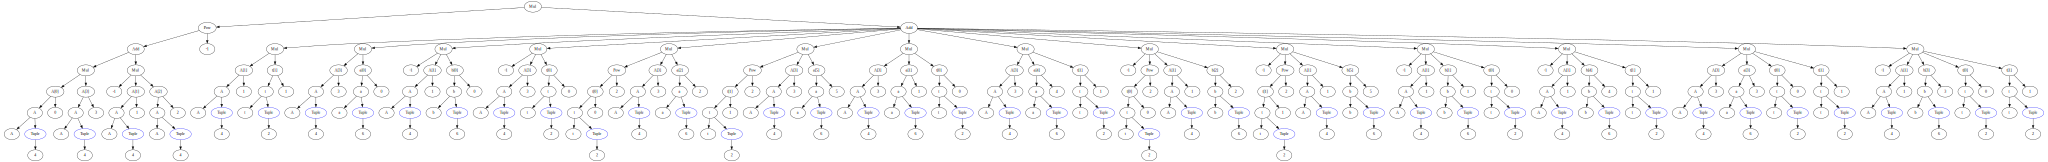

In [19]:
render_sympy_tree(coeffs[0][0])